# Metoda Newtona - optymalizacja funkcji

+ AUTOR: **ŁUKASZ STANISZEWSKI**
+ ZADANIE: **Implementacja metody Newtona i jej badanie w zależności od wymiarowości przestrzeni poszukiwań**
+ POLECENIE: **[LINK](https://github.com/lukasz-staniszewski/ml-algorithms-scratch/blob/main/newton-method-optimization/task_pl.pdf)**

## Import bibliotek
   + numpy -> operacje na macierzach
   + pyplot -> wykresy
   + random -> generowanie liczb
   + pandas -> tabele
   + timeit -> mierzenie czasu 
   + Axes3D -> wykresy 3D

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import random
import timeit
import pandas as pd
from typing import Any, Callable, Union, List

## Zdefiniowanie funkcji, gradientów, hesjanów

#### FUNKCJA 1 
+ $ f(x) = -x^Tx $
+ $ ∇f(x) = -2x $
+ $ H$<sub>$f$</sub>$(x) = −2I$<sub>n</sub>
+ przedstawiony zostanie również wykres funkcji dla wymiaru n=2 oraz n=3:

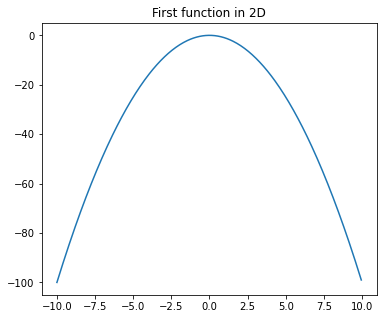

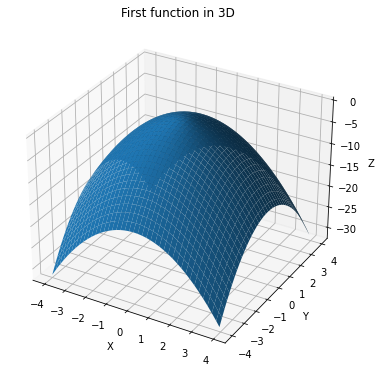

In [50]:
def f1(x):                          
    a = np.matrix(x)
    if a.shape[0] == 1:                                                       # allows to make a column vector as an imput
        a = a.transpose()
    b = a.transpose()
    return (-1 * b * a).item(0)

def gradientf1(x):
    return -2 * np.matrix(x)

def hessianf1(x):
    return -2 * np.identity(len(x))

def draw_function3D(function, functionName, minmax=4):
    fig = plt.figure(figsize=(5, 5))                                        # size of plot
    ax = fig.add_subplot(111, projection="3d")
    ax.set_position([0,0,0.95,1])
    x = y = np.arange(-minmax, minmax, 0.05)                                  # range of x and y
    X, Y = np.meshgrid(x, y)
    zs = np.array([function([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))]) # creating function values for x and y
    Z = zs.reshape(X.shape)
    ax.plot_surface(X, Y, Z, linewidth=0)                                     # creating plot
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(functionName)                                                # setting plot title
    plt.show()

def draw_function2D(function, functionName, minmax=10):
    x = np.arange(-minmax, minmax, 0.05)                                      # range of x
    y=np.array([function(x) for x in x])                                      # creating function values for x
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.set_title(functionName)                                                # setting title
    ax.plot(x, y)                                                             # creating plot
    plt.show()
    
draw_function2D(f1, "First function in 2D")                                   # executing creating 2D function
draw_function3D(f1, "First function in 3D")                                 # executing creating 3D function

#### FUNKCJA 2 
+ $ f(x) = -x^Tx+1.1 \cdot cos(x^Tx)$
+ $ ∇f(x) = -2 \cdot x - 2.2 \cdot x \cdot sin(x^Tx)$
+ $ H_f (x) = − 2 \cdot I_n − 2.2 \cdot I_n \cdot sin(x^Tx) − 4.4 \cdot x \cdot x^T \cdot cos(x^Tx)$
+ w tym przypadku również zostaną przedstawione wykresy funkcji w wymiarowości n=2 i n=3:

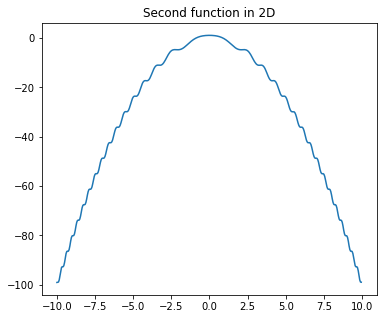

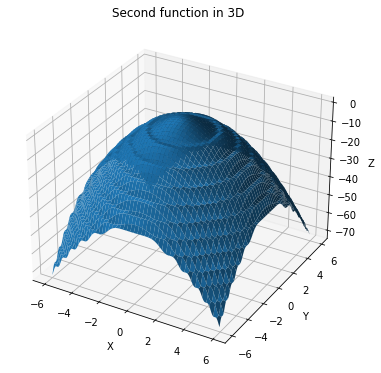

In [51]:
def f2(x):
    a = np.matrix(x)
    if a.shape[0] == 1:
        a = a.transpose()
    b = a.transpose()
    c = b * a
    return (-c + 1.1 * np.cos(c).item(0)).item(0)

def gradientf2(x):
    a = np.matrix(x)
    b = a.transpose()
    c = b * a
    return -2 * a - 2.2 * a * np.sin(c).item(0)

def hessianf2(x):
    a = np.matrix(x)
    b = a.transpose()
    d = np.identity(len(x))
    return -2 * d - 2.2 * d * np.sin(b*a).item(0) - 4.4 * a * b * np.cos(b * a).item(0)

draw_function2D(f2, "Second function in 2D")                                              # executing creating 2D function
draw_function3D(f2, "Second function in 3D", 6)                                            # executing creating 3D function

## Funkcje

In [52]:
def f_info(f: Callable, arg: Any) -> str:
    """Prints algorithm result info

    Args:
        f (function): function handler
        arg (Any): function argument

    Returns:
        str: result info
    """
    info = "f("
    for x in range(arg.shape[0] - 1):
        info += str(round(arg.item(x), 2)) + ", "                                            # printing vector elements
    info += str(round(arg.item(-1), 2)) + ") = " + str(round(f(arg), 2))                     # printing f(vector)
    return info

In [53]:
def generateVector(N: int, floor:int, ceil:int) -> np.ndarray:
    """Generates vector in dimension R^N with elements in range [floor, ceil]

    Args:
        dim (int): dimension
        floor (int): lower bound
        ceil (int): upper bound

    Returns:
        np.ndarray: vector in dimension R^N with elements in range [floor, ceil]
    """
    return np.random.randint(floor, ceil, N).T.reshape(N, 1)

In [54]:
def simulateNewton(start_pos: float, f: Callable, f_gradient: Callable, f_hessian: Callable, beta: float = 0.5, min_steps: int = 1000, want_steps: bool=False) -> Union[np.ndarray, int]:
    """Simulates Newton's method for function maximization problem.

    Args:
        start_pos (float): starting position of simulation
        f (Callable): function to maximize
        f_gradient (Callable): gradient of function to maximize
        f_hessian (Callable): hessian of function to maximize
        beta (float, optional): beta param in Newton's method. Defaults to 0.5.
        min_steps (int, optional): min number of steps in simulation. Defaults to 1000.
        want_steps (bool, optional): if True then steps are returned. Defaults to False.

    Returns:
        Union[np.ndarray, int]: number of steps if want_steps is True, else vector of steps
    """
    pos = start_pos.copy()                                                  # for not edditing given parameter
    f_args = []
    step=0
    while(True):
        f_args.append(pos)                                                  # appending current position to list of positions during simulation
        val_pre = f(pos)
        pos = pos - beta * NewtonStep(pos, f_gradient, f_hessian)           # single Newton step
        val = f(pos)
        if abs(val-val_pre) < 1e-6:
            if want_steps:
                return step                                                 # if there is a need to get number of steps before algorithm finished
            elif step>=min_steps:                               
                return f_args                                               # if there is a need to get positions
        step += 1

In [55]:
def NewtonStep(pos: float, f_gradient: Callable, f_hessian: Callable) -> np.ndarray:
    """Performs single Newton's method step. Returns multiplied inverse of function's hessian at given position by function's gradient at that point.  

    Args:
        pos (float): starting position
        f_gradient (Callable): function's gradient
        f_hessian (Callable): function's hessian

    Returns:
        np.ndarray: multiplied inverse of function's hessian at given position by function's gradient at that point
    """
    return np.linalg.inv(f_hessian(pos)) @ f_gradient(pos)

In [56]:
def simulateGradient(start_pos: float, f: Callable, f_gradient: Callable, f_hessian: Callable, beta: float = 0.5, min_steps: int = 1000, want_steps: bool=False) -> Union[np.ndarray, int]:
    """Simulates Gradient's method for function maximization problem - like simulateNewton but without hessian.

    Args:
        start_pos (float): starting position of simulation
        f (Callable): function to maximize
        f_gradient (Callable): gradient of function to maximize
        f_hessian (Callable): hessian of function to maximize
        beta (float, optional): beta param in Newton's method. Defaults to 0.5.
        min_steps (int, optional): min number of steps in simulation. Defaults to 1000.
        want_steps (bool, optional): if True then steps are returned. Defaults to False.

    Returns:
        Union[np.ndarray, int]: number of steps if want_steps is True, else vector of steps
    """
    pos = start_pos.copy()
    f_args = []
    step=0
    while(True):
        f_args.append(pos)
        val_pre = f(pos)
        pos = pos - beta * f_gradient(pos)
        val = f(pos)
        if abs(val-val_pre) < 1e-6:
            if want_steps:
                return step
            elif step>=min_steps:                               
                return f_args
        step += 1

## SYMULACJE

#### 1. Zachowanie algorytmu realizującego metodę Newtona w celu optymalizacji funkcji $ f(x) = -x^Tx $ w zależności od wartości punktu początkowego
+ wzorując się na wykresach funkcji F1 można zauważyć, że funkcja posiada swoje maksimum globalne w punkcie (0,...,0), gdzie algorytm powinien kończyć swoje działanie,
+ w tym celu zostanie wykonanych 5 symulacji z różnymi wartościami punktu początkowego,
+ zmierzony zostanie czas każdej z tych symulacji (dla następnych badań),
+ założenie: wymiarowość przestrzeni poszukiwań n = 3,
+ składniki punktu początkowego będą liczbami z zakresu <-99, 99>,
+ założenie: $ β = 0.05 $

In [57]:
def get_f_infos(f: Callable, sim_steps: List) -> List:
    """Returns list of information about function's values during simulation.

    Args:
        f (Callable): function to maximize
        sim_steps (List): list of steps in simulations

    Returns:
        List: list of information about function's values during simulation
    """
    sim_fun_values = []
    for steps in sim_steps:
        fun_values = []
        for step in steps:
            fun_values.append(f_info(f, step))
        sim_fun_values.append(fun_values)
    return sim_fun_values

+ Symulacje:

In [58]:
sim_times = []                                                                                   # list of time for every simulation
sim_steps = []                                                                                   # list of steps for every simulation
positions = [[1, 2, 1], [-10, 20, 30], [50, 45, 50], [-80, 80, 80], [10, 10, 10]] 

for simulation in range(5):
    starting_point = np.matrix(positions[simulation]).transpose()
    sim_steps.append(simulateNewton(starting_point, f1, gradientf1, hessianf1, 0.05, 210, False))
    sim_times.append(round(timeit.timeit(lambda: simulateNewton(starting_point, f1, gradientf1, hessianf1, 0.05, 210, True),number = 1),3))

sim_fun_values = get_f_infos(f1,sim_steps)                                                      # list of values of functions for every simulation

+ Tabela pokazująca dla każdej symulacji i kroku algorytmu pozycję i wartość funkcji celu w tej pozycji:

In [59]:
ITERATIONS = 5                                                                                  # assumption
simulations = {}
counter = ["first", "second", "third", "fourth", "fifth"]

for x in range(ITERATIONS):
    col1 = f"{counter[x]} simulation"
    simulations[col1] = sim_fun_values[x][:200]

df = pd.DataFrame(simulations)                                                                  # creating dataframe from dictionary
df.index.name = 'step'
pd.set_option("display.max_rows", None, "display.max_columns", None)
df

,first simulation,second simulation,third simulation,fourth simulation,fifth simulation
step,,,,,
0,"f(1, 2, 1) = -6","f(-10, 20, 30) = -1400","f(50, 45, 50) = -7025","f(-80, 80, 80) = -19200","f(10, 10, 10) = -300"
1,"f(0.95, 1.9, 0.95) = -5.42","f(-9.5, 19.0, 28.5) = -1263.5","f(47.5, 42.75, 47.5) = -6340.06","f(-76.0, 76.0, 76.0) = -17328.0","f(9.5, 9.5, 9.5) = -270.75"
2,"f(0.9, 1.8, 0.9) = -4.89","f(-9.03, 18.05, 27.07) = -1140.31","f(45.12, 40.61, 45.12) = -5721.91","f(-72.2, 72.2, 72.2) = -15638.52","f(9.03, 9.03, 9.03) = -244.35"
3,"f(0.86, 1.71, 0.86) = -4.41","f(-8.57, 17.15, 25.72) = -1029.13","f(42.87, 38.58, 42.87) = -5164.02","f(-68.59, 68.59, 68.59) = -14113.76","f(8.57, 8.57, 8.57) = -220.53"
4,"f(0.81, 1.63, 0.81) = -3.98","f(-8.15, 16.29, 24.44) = -928.79","f(40.73, 36.65, 40.73) = -4660.53","f(-65.16, 65.16, 65.16) = -12737.67","f(8.15, 8.15, 8.15) = -199.03"
5,"f(0.77, 1.55, 0.77) = -3.59","f(-7.74, 15.48, 23.21) = -838.23","f(38.69, 34.82, 38.69) = -4206.13","f(-61.9, 61.9, 61.9) = -11495.75","f(7.74, 7.74, 7.74) = -179.62"
6,"f(0.74, 1.47, 0.74) = -3.24","f(-7.35, 14.7, 22.05) = -756.5","f(36.75, 33.08, 36.75) = -3796.03","f(-58.81, 58.81, 58.81) = -10374.91","f(7.35, 7.35, 7.35) = -162.11"
7,"f(0.7, 1.4, 0.7) = -2.93","f(-6.98, 13.97, 20.95) = -682.74","f(34.92, 31.43, 34.92) = -3425.92","f(-55.87, 55.87, 55.87) = -9363.36","f(6.98, 6.98, 6.98) = -146.3"
8,"f(0.66, 1.33, 0.66) = -2.64","f(-6.63, 13.27, 19.9) = -616.18","f(33.17, 29.85, 33.17) = -3091.89","f(-53.07, 53.07, 53.07) = -8450.43","f(6.63, 6.63, 6.63) = -132.04"


+ jak widać każda z symulacji zakończyła się sukcesem (odnaleziono maksimum funkcji celu w punkcie (0,0,0))
+ czasy poszczególnych symulacji:

In [60]:
times = {}
times["time (s)"] = sim_times
df = pd.DataFrame(times,index=counter)
df

,time (s)
first,0.011
second,0.017
third,0.019
fourth,0.017
fifth,0.013


+ Wnioski:
    + o ile widać, że czasy przeprowadzania poszczególnych symulacji nie różnią się bardzo znacząco, można zauważyć, że minimalnie więcej czasu zajmuje przeprowadzenie czwartej z symulacji, gdzie punktem początkowym jest punkt P=(-80, 80, 80), który jest najbardziej oddalonym punktem od punktu (0, 0, 0)
    + wzorując się na danych zawartych w tabeli, można również zauważyć, że najwięcej kroków algorytmu zostało przeprowadzone również w czwartej symulacji (najpóźniej został ustalony punkt(0,0,0), bo dopiero w 189 kroku)
    + można więc wyciągnąć wniosek, że czym dalej znajduje się punkt początkowy od punktu, w którym występuje maximum, tym symulacja zajmuje więcej czasu i więcej kroków algorytmu zostaje wykonanych (oczywiście, zakładając $β=0.05$)
    + aby upewnić tę hipotezę, wykonana zostanie dodatkowo symulacja z punktem początkowym znajdującym się znacznie dalej - (-1000, 2000, 50000) i zgodnie z przypuszczeniami, symulacja zajęła znacznie więcej czasu (ok. 5 razy więcej czasu) i kroków algorytmu (ok. 130 więcej)

In [61]:
starting_point = np.matrix([-1000, 2000, 50000]).transpose()                                # starting point
args = simulateNewton(starting_point, f1, gradientf1, hessianf1, 0.05, 350)                 # position in every step of alg
time = round(timeit.timeit(lambda: simulateNewton(starting_point, f1, gradientf1, hessianf1, 0.05),number = 1),3) # time of simulation
step = simulateNewton(starting_point, f1, gradientf1, hessianf1, 0.05, 600, True)           # number of steps of algorithm

print(f"TIME = {time}s")
print(f"NUMBER OF ALGORITHM STEPS = {step}")

TIME = 0.13s
NUMBER OF ALGORITHM STEPS = 323


#### 2. Sprawdzenie jak szybko zostanie przeprowadzona maksymalizacja funkcji $ f(x) = -x^Tx $ metodą Newtona w zależności od wymiarowości przestrzeni poszukiwań n:
+ w tym celu wykonam 5 symulacji na różnych wymiarowościach przestrzeni poszukiwań n,
+ zmierze czas każdej z tych symulacji,
+ zakładam w tym badaniu, że wektor x = $[100, 100, ..., 100, 100]^T, z\in{\displaystyle \mathbb {Z} }$,
+ badanie zostanie wykonane dla n = 5, 10, 15, 20, 25,
+ tu znów $ β = 0.05 $.


Symulacja:

In [62]:
z = 100
sim_times = []
sim_steps = []
number_of_alg_steps = []
vect = []

for dimension in range(5):
    for _ in range(5):
        vect.append(z)
    starting_point = np.matrix(vect).transpose()
    number_of_alg_steps.append(simulateNewton(starting_point, f1, gradientf1, hessianf1, 0.05, 500, True))
    sim_steps.append(simulateNewton(starting_point, f1, gradientf1, hessianf1, 0.05, 500))
    sim_times.append(round(timeit.timeit(lambda: simulateNewton(starting_point, f1, gradientf1, hessianf1, 0.05, 500, True),number = 1),3))

sim_fun_values = get_f_infos(f1, sim_steps)

+ **PRZEDSTAWIENIE WYNIKÓW W FORMIE TABELI:**

In [63]:
simulations = {}
identificators = []
dim = 5
for x in range(5):
    col1 = f"n={dim}"
    identificators.append(col1)
    dim += 5
    simulations[col1] = sim_fun_values[x][:200]                                                    # first 200 results
df = pd.DataFrame(simulations)
df.index.name = 'step'
pd.set_option("display.max_rows", None, "display.max_columns", None, 'display.max_colwidth', None)
df

,n=5,n=10,n=15,n=20,n=25
step,,,,,
0,"f(100, 100, 100, 100, 100) = -50000","f(100, 100, 100, 100, 100, 100, 100, 100, 100, 100) = -100000","f(100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100) = -150000","f(100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100) = -200000","f(100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100) = -250000"
1,"f(95.0, 95.0, 95.0, 95.0, 95.0) = -45125.0","f(95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0) = -90250.0","f(95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0) = -135375.0","f(95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0) = -180500.0","f(95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0) = -225625.0"
2,"f(90.25, 90.25, 90.25, 90.25, 90.25) = -40725.31","f(90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25) = -81450.62","f(90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25) = -122175.94","f(90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25) = -162901.25","f(90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25, 90.25) = -203626.56"
3,"f(85.74, 85.74, 85.74, 85.74, 85.74) = -36754.59","f(85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74) = -73509.19","f(85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74) = -110263.78","f(85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74) = -147018.38","f(85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74, 85.74) = -183772.97"
4,"f(81.45, 81.45, 81.45, 81.45, 81.45) = -33171.02","f(81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45) = -66342.04","f(81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45) = -99513.06","f(81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45) = -132684.09","f(81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45, 81.45) = -165855.11"
5,"f(77.38, 77.38, 77.38, 77.38, 77.38) = -29936.85","f(77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38) = -59873.69","f(77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38) = -89810.54","f(77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38) = -119747.39","f(77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38, 77.38) = -149684.23"
6,"f(73.51, 73.51, 73.51, 73.51, 73.51) = -27018.0","f(73.51, 73.51, 73.51, 73.51, 73.51, 73.51, 73.51, 73.51, 73.51, 73.51) = -54036.01","f(73.51, 73.51, 73.51, 73.51, 73.51, 73.51, 73.51, 73.51, 73.51, 73.51, 73.51, 73.51, 73.51, 73.51, 73.51) = -81054.01","f(73.51, 73.51, 73.51, 73.51, 73.51, 73.51, 73.51, 73.51, 73.51, 73.51, 73.51, 73.51, 73.51, 73.51, 73.51, 73.51, 73.51, 73.51, 73.51, 73.51) = -108072.02","f(73.51, 73.51, 73.51, 73.51, 73.51, 73.51, 73.51, 73.51, 73.51, 73.51, 73.51, 73.51, 73.51, 73.51, 73.51, 73.51, 73.51, 73.51, 73.51,

+ Czasy i liczby kroków:

In [64]:
results = {}

times["time (s)"] = sim_times
times["algorithm steps"] = number_of_alg_steps

df = pd.DataFrame(times,index=identificators)
df.index.name = "dim"
df

,time (s),algorithm steps
dim,,
n=5,0.038,218
n=10,0.030,225
n=15,0.031,229
n=20,0.023,231
n=25,0.027,234


+ Zobrazowanie rezultatów w wykresach:

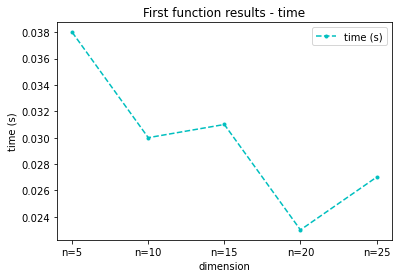

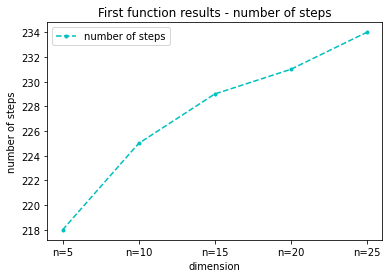

<Figure size 432x288 with 0 Axes>

In [65]:
def create_plot(title, indexes, values1, val1_name, xname, yname):
    plt.plot(indexes, values1, marker = '.', color = "c", linestyle="--", label = val1_name)
    plt.title(title)
    plt.ylabel(yname)
    plt.xlabel(xname)
    plt.legend()
    plt.show()
    plt.clf()

create_plot("First function results - time", identificators, sim_times, "time (s)", "dimension", "time (s)")
create_plot("First function results - number of steps", identificators, number_of_alg_steps, "number of steps", "dimension", "number of steps")

+ jak widać w przypadku gdy $ β = 0.05 $ optymalizacja wykonuje się minimalnie wolniej dla większej wymiarowości przestrzeni poszukiwań
+ wykonana zostanie teraz symulacja w przypadku gdy $ β = 1 $ 

#### 3. Zależność dla funkcji $ f(x) = -x^Tx $ w przypadku gdy $ β = 1 $
+ przeprowadzona zostanie symulacja podobna do tej z podpunktu 2., jednak z założeniem, że $ β = 1 $
+ dodatkowo dla każdej symulacji losowane są składniki punktu początkowego, a wymiarowość zwiększa się o 5 z każdą symulacją

In [66]:
z = 100
sim_times = []
sim_steps = []
number_of_alg_steps = []
vect = []

for dimension in range(5):
    for _ in range(5):
        vect.append(random.randint(-1000, 1000))
    starting_point = np.matrix(vect).transpose()
    number_of_alg_steps.append(simulateNewton(starting_point, f1, gradientf1, hessianf1, 1, 500, True))
    sim_times.append(round(timeit.timeit(lambda: simulateNewton(starting_point, f1, gradientf1, hessianf1, 1, 500),number = 1),10))

sim_fun_values = get_f_infos(f1, sim_steps)

+ Wyniki symulacji:

In [67]:
results = {}

times["time (s)"] = sim_times
times["algorithm steps"] = number_of_alg_steps
df = pd.DataFrame(times,index=identificators)
df.index.name = "dim"
df

,time (s),algorithm steps
dim,,
n=5,0.052592,1
n=10,0.047304,1
n=15,0.056252,1
n=20,0.053652,1
n=25,0.051822,1


+ Wykresy:

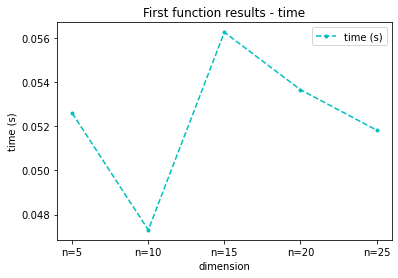

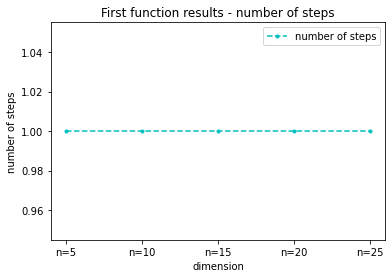

<Figure size 432x288 with 0 Axes>

In [68]:
create_plot("First function results - time", identificators, sim_times, "time (s)", "dimension", "time (s)")
create_plot("First function results - number of steps", identificators, number_of_alg_steps, "number of steps", "dimension", "number of steps")

+ w tym przypadku, funkcja czasu i liczby kroków nie zależy ani od wymiarowości przestrzeni poszukiwań ani od wartości punktu początkowego i w każdym z przypadków algorytm optymalizuje funkcję już w pierwszym kroku,
+ oznacza to, że $ β=1 $ jest odpowiednim parametrem dla tej optymalizacji i powinno się go używać dla tej funkcji 

#### 4. Sprawdzenie jak zadziała metoda Newtona dla optymalizacji funkcji $ f(x) = -x^Tx + 1.1 \cdot cos(x^Tx)$ w zależności od wartości punktu początkowego
+ wzorując się na wykresach F2, można zauważyć, że funkcja posiada swoje maksimum globalne w punckie (0,...,0), również liczne minima i maksima lokalne, dlatego też algorytm dla różnych wartości punktu początkowego może dochodzić do innej pozycji,
+ w tym celu wykonane zostanie 5 symulacji na różnych wartościach punktu początkowego,
+ założenie: wymiarowość przestrzeni poszukiwań n = 3,
+ składniki punktu początkowego będą różnymi liczbami z zakresu <-99, 99>,
+ niech $ β = 1 $.

Symulacja:

In [69]:
sim_times = []
sim_steps = []
number_of_alg_steps = []
starting_points = [[0.5,0.5, 0.5],[30, 12, 34],[-10,12,13],[2, 2, 3],[60, 23, 45]]            # starting points

for simulation in range(5):
    starting_point = np.matrix(starting_points[simulation]).transpose()
    sim_steps.append(simulateNewton(starting_point, f2, gradientf2, hessianf2, 1, 600))
    number_of_alg_steps.append(simulateNewton(starting_point, f2, gradientf2, hessianf2, 1, 600, True))
    sim_times.append(round(timeit.timeit(lambda: simulateNewton(starting_point, f2, gradientf2, hessianf2, 1, 600, True),number = 1),10))

sim_fun_values = get_f_infos(f2, sim_steps)

+ Zmieniająca się pozycji:

In [70]:
ITERATIONS = 5
simulations = {}
counter = ["first", "second", "third", "fourth", "fifth"]

for x in range(ITERATIONS):
    col1 = f"{counter[x]} simulation"
    simulations[col1] = sim_fun_values[x][:50]

df = pd.DataFrame(simulations)
df.index.name = 'step'
pd.set_option("display.max_rows", None, "display.max_columns", None)
df

,first simulation,second simulation,third simulation,fourth simulation,fifth simulation
step,,,,,
0,"f(0.5, 0.5, 0.5) = 0.05","f(30, 12, 34) = -2199.3","f(-10, 12, 13) = -413.13","f(2, 2, 3) = -17.3","f(60, 23, 45) = -6155.02"
1,"f(0.2, 0.2, 0.2) = 0.97","f(29.98, 11.99, 33.98) = -2197.56","f(-9.99, 11.99, 12.99) = -413.1","f(1.99, 1.99, 2.98) = -17.31","f(60.01, 23.0, 45.01) = -6155.97"
2,"f(0.04, 0.04, 0.04) = 1.1","f(29.98, 11.99, 33.98) = -2197.57","f(-10.0, 11.99, 12.99) = -413.15","f(1.99, 1.99, 2.99) = -17.31","f(60.01, 23.0, 45.01) = -6155.98"
3,"f(0.0, 0.0, 0.0) = 1.1","f(29.98, 11.99, 33.98) = -2197.57","f(-10.0, 12.0, 13.0) = -413.15","f(1.99, 1.99, 2.99) = -17.31","f(60.01, 23.0, 45.01) = -6155.98"
4,"f(0.0, 0.0, 0.0) = 1.1","f(29.98, 11.99, 33.98) = -2197.57","f(-10.0, 12.0, 13.0) = -413.15","f(1.99, 1.99, 2.99) = -17.31","f(60.01, 23.0, 45.01) = -6155.98"
5,"f(0.0, 0.0, 0.0) = 1.1","f(29.98, 11.99, 33.98) = -2197.57","f(-10.0, 12.0, 13.0) = -413.15","f(1.99, 1.99, 2.99) = -17.31","f(60.01, 23.0, 45.01) = -6155.98"
6,"f(0.0, 0.0, 0.0) = 1.1","f(29.98, 11.99, 33.98) = -2197.57","f(-10.0, 12.0, 13.0) = -413.15","f(1.99, 1.99, 2.99) = -17.31","f(60.01, 23.0, 45.0) = -6155.98"
7,"f(0.0, 0.0, 0.0) = 1.1","f(29.98, 11.94, 34.0) = -2197.57","f(-10.0, 12.0, 13.0) = -413.15","f(1.99, 1.99, 2.99) = -17.31","f(60.01, 23.0, 45.0) = -6155.98"
8,"f(0.0, 0.0, 0.0) = 1.1","f(29.98, 11.94, 34.0) = -2197.57","f(-10.0, 12.0, 13.0) = -413.15","f(1.99, 1.99, 2.99) = -17.31","f(60.01, 23.0, 45.0) = -6155.98"


+ zgodnie z przypuszczeniami, dla różnych punktów algorytm zachowuje się inaczej:
    * w przypadku symulacji 1 , 2 i 4 funkcja znajduje maksima lokalne (w przypadku 1 nawet globalne),
    * w przypadkach symulacji 3 i 5 funkcja znajduje minima lokalne;
+ można stąd wywnioskować że algorytm przeprowadza wartość punktu początkowego do najbliższego ekstremum;
+ dodatkowo zostają zestawione wyniki czasu trwania symulacji i liczby kroków algorytmu dla poszczególnych symulacji, które pokazują że wartość punktu początkowego nie wpływa na te rezultaty;

In [71]:
times = {}

times["time (s)"] = sim_times
times["algorithm steps"] = number_of_alg_steps

df = pd.DataFrame(times,index=counter)
df.index.name = "dim"
df

,time (s),algorithm steps
dim,,
first,0.000616,3
second,0.000815,4
third,0.000801,4
fourth,0.000491,2
fifth,0.000651,3


#### 5. Badanie zachowania algorytmu realizującego metodę Newtona dla problemu optymalizacji funkcji $ f(x) = -x^Tx + 1.1 \cdot cos(x^Tx)$ w zależności od wymiarowości przestrzeni poszukiwań n:
+ zostanie wykonane 5 symulacji, odpowiednio dla: n=100, n=200, n=300, n=400, n=500

In [72]:
sim_times = []
sim_steps = []
number_of_alg_steps = []
vect = []

for simulation in range(5):
    for _ in range(10):
        vect.append(50)
    starting_point = np.matrix(vect).transpose()
    number_of_alg_steps.append(simulateNewton(starting_point, f2, gradientf2, hessianf2, 1, 500, True))
    sim_times.append(round(timeit.timeit(lambda: simulateNewton(starting_point, f2, gradientf2, hessianf2, 1, 500, True),number = 1),10))

In [73]:
results = {}
identificators=["n=10", "n=20", "n=30", "n=40", "n=50"]
times["time (s)"] = sim_times
times["algorithm steps"] = number_of_alg_steps

df = pd.DataFrame(times,index=identificators)
df.index.name="dim"
df

,time (s),algorithm steps
dim,,
n=10,0.001542,3
n=20,0.001893,4
n=30,0.000887,3
n=40,0.001075,3
n=50,0.002243,6


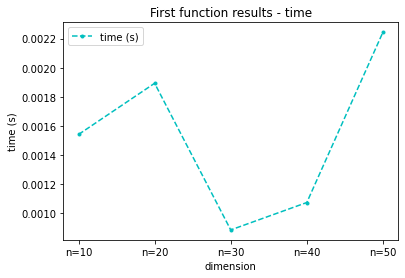

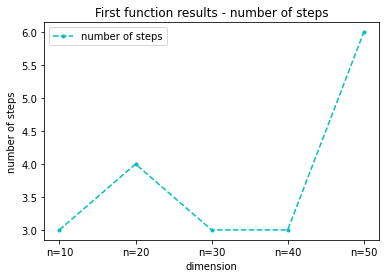

<Figure size 432x288 with 0 Axes>

In [74]:
create_plot("First function results - time", identificators, sim_times, "time (s)", "dimension", "time (s)")
create_plot("First function results - number of steps", identificators, number_of_alg_steps, "number of steps", "dimension", "number of steps")

+ i w tym przypadku również widać, że wymiarowość przestrzeni przeszukiwań nie ma dużego znaczenia na czas działania i liczbę kroków algorytmu realizującego metodę Newtona dla optymalizacji funkcji celu